In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Define the ticker symbol and period
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)

# Fetching daily data from the start date up to the current date
data = tickerData.history(period='1d', start='2010-1-1')
data = data.reset_index()

# Calculate the Average True Range (ATR)
atr_period = 14  # Typical period used for ATR
data['High_Low'] = data['High'] - data['Low']
data['High_Close'] = (data['High'] - data['Close'].shift()).abs()
data['Low_Close'] = (data['Low'] - data['Close'].shift()).abs()
data['TR'] = data[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Define look back and holding periods
look_back = 3
holding_period = 3

# Calculate returns and signals
data['return'] = data['Close'] / data['Close'].shift(look_back) - 1
data['signal'] = np.where(data['return'] > 0, 1, 0)

# Initialize the positions column
data['positions'] = 0

# Loop through the DataFrame to simulate the strategy
for j in range(len(data) - holding_period):
    if data.loc[j, 'signal'] > 0:  # If there is a signal to enter a position
        entry_price = data.loc[j, 'Open']
        stop_loss_price = entry_price - data.loc[j, 'ATR']
        take_profit_price = entry_price + data.loc[j, 'ATR']
        data.loc[j, 'positions'] = 1  # Enter the position

        # Check for stop loss and take profit conditions for the next `holding_period` days
        for y in range(1, holding_period + 1):
            day_high = data.loc[j + y, 'High']
            day_low = data.loc[j + y, 'Low']

            # Check take profit and stop loss conditions
            if day_high >= take_profit_price:
                data.loc[j + y, 'positions'] = 0  # Exit the position at take profit
                break  # No need to check further
            elif day_low <= stop_loss_price:
                data.loc[j + y, 'positions'] = 0  # Exit the position at stop loss
                break  # No need to check further

        # If neither TP nor SL is hit, exit the position at the end of holding period
        if data.loc[j + holding_period, 'positions'] == 1:
            data.loc[j + holding_period, 'positions'] = 0

# Optional: Calculate and print the strategy's return
data['strategy_return'] = data['positions'].shift(1) * data['return']
cumulative_strategy_return = data['strategy_return'].cumsum()
data['cumulative_return'] = cumulative_strategy_return
print("Cumulative Strategy Return: ", cumulative_strategy_return.iloc[-1])

data['default_cumulative_return'] = data['return'].cumsum()

Cumulative Strategy Return:  17.36590436020707


In [16]:
data.index = data['Date']

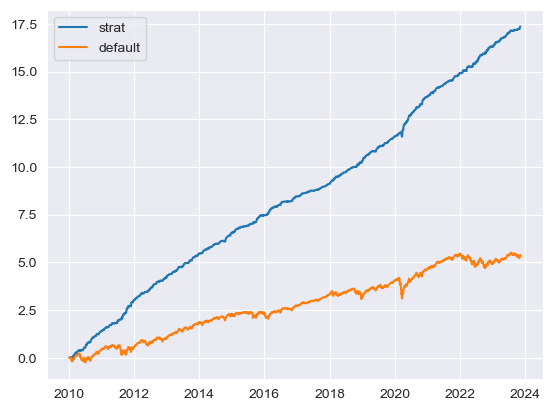

In [17]:
plt.plot(data['cumulative_return'],label = 'strat')
plt.plot(data['default_cumulative_return'],label = 'default')
plt.legend()
plt.show()

In [22]:
def calculate_first_entries(positions):
    """
    Calculate the number of trading opportunities based on the first occurrence of 1 in the positions series.

    Parameters:
    - positions: pandas Series with binary values where 1 indicates an entry point for a trade

    Returns:
    - first_entries: The number of first entry points for trades
    """
    # Shift the series by 1 to compare with the previous value, fill the first NA with 0
    shifted_positions = positions.shift(1).fillna(0)
    # Identify the transitions from 0 to 1 which are our first entries
    first_entries = ((positions == 1) & (shifted_positions == 0)).sum()
    return first_entries

# Example usage:
# Assuming data is your dataframe and 'positions' is a column in your dataframe
num_trading_opportunities = calculate_first_entries(data['positions'])
print(f"Number of trading opportunities: {num_trading_opportunities}")

# Calculate the Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate the Sharpe Ratio for a set of returns.

    Parameters:
    - returns: Array of returns (e.g., daily returns)
    - risk_free_rate: Risk-free rate of return, defaults to 0

    Returns:
    - sharpe_ratio: The Sharpe Ratio
    """
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(data['strategy_return'])
print(f"Sharpe Ratio: {sharpe_ratio}")

def calculate_win_loss_ratio(data):
    """
    Calculate the win/loss ratio for trades based on entry and exit points.

    Parameters:
    - data: DataFrame with 'positions' and 'Close' columns, where 'positions' indicates trade entries with 1

    Returns:
    - win_loss_ratio: The win/loss ratio
    """
    # Initialize the list to store returns
    trade_returns = []

    # Track if currently in trade
    in_trade = False
    entry_price = None

    # Iterate through the dataframe
    for index, row in data.iterrows():
        # Check for trade entry
        if row['positions'] == 1 and not in_trade:
            in_trade = True
            entry_price = row['Close']

        # Check for trade exit
        elif row['positions'] == 0 and in_trade:
            in_trade = False
            exit_price = row['Close']
            trade_returns.append((exit_price - entry_price) / entry_price)

    # Separate wins and losses
    wins = [ret for ret in trade_returns if ret > 0]
    losses = [ret for ret in trade_returns if ret <= 0]

    # Calculate win/loss ratio
    win_loss_ratio = len(wins) / len(losses) if losses else np.inf
    return win_loss_ratio

# Example usage:
win_loss_ratio = calculate_win_loss_ratio(data)
print(f"Win/Loss Ratio: {win_loss_ratio}")


Number of trading opportunities: 433
Sharpe Ratio: 0.4257894732864378
Win/Loss Ratio: 0.7745901639344263


In [24]:
data['return']

Date
2010-01-04 00:00:00-05:00         NaN
2010-01-05 00:00:00-05:00         NaN
2010-01-06 00:00:00-05:00         NaN
2010-01-07 00:00:00-05:00    0.007589
2010-01-08 00:00:00-05:00    0.008273
                               ...   
2023-11-02 00:00:00-04:00    0.036502
2023-11-03 00:00:00-04:00    0.039431
2023-11-06 00:00:00-05:00    0.030829
2023-11-07 00:00:00-05:00    0.014323
2023-11-08 00:00:00-05:00    0.005889
Name: return, Length: 3487, dtype: float64

In [26]:
import statsmodels.api as sm

# Create a new DataFrame with the columns for regression
regression_df = pd.DataFrame({
    'strategy_returns': data['strategy_return'],
    'market_returns': data['return']
})

# Drop rows with NaN values in either column
regression_df.dropna(subset=['strategy_returns', 'market_returns'], inplace=True)

# Check for infinite values and replace them with NaN, then drop those rows
regression_df.replace([np.inf, -np.inf], np.nan, inplace=True)
regression_df.dropna(subset=['strategy_returns', 'market_returns'], inplace=True)

# Add a constant to the market returns for the regression intercept
X = sm.add_constant(regression_df['market_returns'])  # Independent variable, with constant added
y = regression_df['strategy_returns']  # Dependent variable

# Create the OLS model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print out the statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     4001.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:37:58   Log-Likelihood:                 11885.
No. Observations:                3484   AIC:                        -2.377e+04
Df Residuals:                    3482   BIC:                        -2.375e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0042      0.000     31.

Coefficient for const (Alpha): The intercept term (often interpreted as the expected return of the strategy not explained by market movements) is 0.0042, or 0.42% per the period analyzed (assuming it's daily, this would be per day). The p-value is less than 0.05, which suggests that the alpha is statistically significantly different from 0 at conventional levels, indicating that the strategy, on average, yields a positive return that is not explained by the market's performance.

Coefficient for market_returns (Beta): The coefficient of 0.4753 suggests that for every 1% increase in market returns, the strategy returns 0.4753%. This beta is significantly different from 0, as indicated by its p-value.

p-values: Both the alpha and beta have p-values less than 0.05, which means they are statistically significant at the 5% level.

Confidence intervals: The 95% confidence intervals for both alpha and beta do not contain 0, further confirming their significance.

Durbin-Watson Statistic: The Durbin-Watson statistic is close to 1.5, which suggests there is no strong evidence of autocorrelation in the residuals of your model.

Omnibus and Jarque-Bera Tests: These tests indicate whether the residuals are normally distributed. A Prob(Omnibus) or Prob(JB) close to 0 implies the residuals are not normally distributed, which is the case here.

Kurtosis: A kurtosis greater than 3 (which is the kurtosis of a normal distribution) suggests that the tails are fatter than a normal distribution. In this case, the kurtosis is significantly higher than 3, suggesting the presence of outliers or large jumps in your return distribution.

Skew: Skewness measures the asymmetry of the probability distribution of your returns. A skewness of 1.005 indicates a moderate right skew, meaning there are more unusually large returns than large losses in your strategy's return distribution.

In theory, a strategy with a significant alpha (indicating performance above the benchmark after accounting for market exposure) and a positive beta (indicating a positive correlation with the market) might be considered good. However, the real-world effectiveness of the strategy also depends on factors not captured in this model, such as:

Transaction Costs: These can significantly eat into returns and are not accounted for in the above analysis.
Market Impact: Especially for larger strategies, the act of trading can itself affect the market price.
Risk Adjusted Returns: You may want to look at measures like the Sharpe ratio, which adjusts for the volatility of the strategy's returns.
Out-of-Sample Performance: It's crucial to test how the strategy performs on data that was not used in the model fitting process.
Stability Over Time: Market conditions change, and strategies that work well in one period may not work in another.

If your goal is to establish that your trading strategy is statistically significant, regressing against SPY returns can still be useful, but your focus would be slightly different:

Alpha Significance: In this regression, you're particularly interested in the alpha (the intercept). If the alpha is statistically significant (with a low p-value), it indicates that your strategy's performance is not simply a result of market movements. In other words, your strategy is earning a return that is not explained by the overall market returns, which suggests that the strategy may have merit on its own.

Strategy Return Independence: If your strategy has a low R-squared in this regression, it means that the strategy's returns are not well explained by the market's returns, suggesting a degree of independence from overall market performance. This can be desirable if you're looking for diversification or if you're trying to prove that your strategy can generate alpha irrespective of market conditions.

T-Statistic for Alpha: You would look at the t-statistic for the alpha term to judge whether the performance above or below the market is statistically significant. A high absolute value of the t-statistic (typically greater than 2 in absolute value for a 95% confidence level) indicates that the alpha is significantly different from zero.

Non-Market Factors: Additionally, you might want to examine other factors that could affect your strategy's performance, such as different market sectors, interest rates, economic indicators, or specific events. In this case, a multi-factor regression model might be more appropriate.